# Introducing Scikit-Learn

There are several Python libraries which provide solid implementations of a range of machine learning algorithms.
One of the best known is [Scikit-Learn](http://scikit-learn.org), a package that provides efficient versions of a large number of common algorithms.
Scikit-Learn is characterized by a clean, uniform, and streamlined API, as well as by very useful and complete online documentation.
A benefit of this uniformity is that once you understand the basic use and syntax of Scikit-Learn for one type of model, switching to a new model or algorithm is very straightforward.

This notebook provides an overview of the Scikit-Learn API; a solid understanding of these API elements will form the foundation for understanding the deeper practical discussion of machine learning algorithms and approaches in the rest of the course.

We will start by covering *data representation* in Scikit-Learn, followed by covering the *Estimator* API, and finally go through a more interesting example of using these tools for exploring a set of images of hand-written digits.

## Data Representation in Scikit-Learn

Machine learning is about creating models from data: for that reason, we'll start by discussing how data can be represented in order to be understood by the computer.
The best way to think about data within Scikit-Learn is in terms of tables of data.

### Data as table

A basic table is a two-dimensional grid of data, in which the rows represent individual elements of the dataset, and the columns represent quantities related to each of these elements.
For example, consider the [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), famously analyzed by Ronald Fisher in 1936.
We can download this dataset in the form of a Pandas ``DataFrame`` using the [seaborn](http://seaborn.pydata.org/) library:

In [1]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Here each row of the data refers to a single observed flower, and the number of rows is the total number of flowers in the dataset.
In general, we will refer to the rows of the matrix as *samples*, and the number of rows as ``n_samples``.

Likewise, each column of the data refers to a particular quantitative piece of information that describes each sample.
In general, we will refer to the columns of the matrix as *features*, and the number of columns as ``n_features``.

#### Features matrix

This table layout makes clear that the information can be thought of as a two-dimensional numerical array or matrix, which we will call the *features matrix*.
By convention, this features matrix is often stored in a variable named ``X``.
The features matrix is assumed to be two-dimensional, with shape ``[n_samples, n_features]``, and is most often contained in a NumPy array or a Pandas ``DataFrame``, though some Scikit-Learn models also accept SciPy sparse matrices.

The samples (i.e., rows) always refer to the individual objects described by the dataset.
For example, the sample might be a flower, a person, a document, an image, a sound file, a video, an astronomical object, or anything else you can describe with a set of quantitative measurements.

The features (i.e., columns) always refer to the distinct observations that describe each sample in a quantitative manner.
Features are generally real-valued, but may be Boolean or discrete-valued in some cases.

#### Target array

In addition to the feature matrix ``X``, we also generally work with a *label* or *target* array, which by convention we will usually call ``y``.
The target array is usually one dimensional, with length ``n_samples``, and is generally contained in a NumPy array or Pandas ``Series``.
The target array may have continuous numerical values, or discrete classes/labels.
While some Scikit-Learn estimators do handle multiple target values in the form of a two-dimensional, ``[n_samples, n_targets]`` target array, we will primarily be working with the common case of a one-dimensional target array.

Often one point of confusion is how the target array differs from the other features columns. The distinguishing feature of the target array is that it is usually the quantity we want to *predict from the data*: in statistical terms, it is the dependent variable.
For example, in the preceding data we may wish to construct a model that can predict the species of flower based on the other measurements; in this case, the ``species`` column would be considered the target array.

With this target array in mind, we can use Seaborn (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)) to conveniently visualize the data:

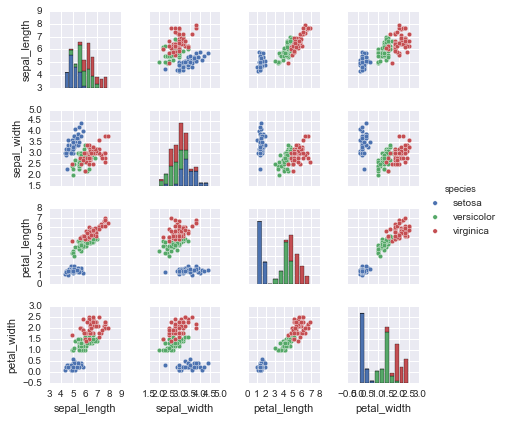

In [2]:
%matplotlib inline
import seaborn as sns; sns.set()
sns.pairplot(iris, hue='species', size=1.5);

For use in Scikit-Learn, we will extract the features matrix and target array from the ``DataFrame``, which we can do using some of the Pandas ``DataFrame`` operations discussed in the [Chapter 3](03.00-Introduction-to-Pandas.ipynb):

In [3]:
X_iris = iris.drop('species', axis=1)
X_iris.shape

(150, 4)

In [4]:
y_iris = iris['species']
y_iris.shape

(150,)

To summarize, the expected layout of features and target values is visualized in the following diagram:

![](assets/samples-features.png)


With this data properly formatted, we can move on to consider the *estimator* API of Scikit-Learn:

## Scikit-Learn's Estimator API

The Scikit-Learn API is designed with the following guiding principles in mind, as outlined in the [Scikit-Learn API paper](http://arxiv.org/abs/1309.0238):

- *Consistency*: All objects share a common interface drawn from a limited set of methods, with consistent documentation.

- *Inspection*: All specified parameter values are exposed as public attributes.

- *Limited object hierarchy*: Only algorithms are represented by Python classes; datasets are represented
  in standard formats (NumPy arrays, Pandas ``DataFrame``s, SciPy sparse matrices) and parameter
  names use standard Python strings.

- *Composition*: Many machine learning tasks can be expressed as sequences of more fundamental algorithms,
  and Scikit-Learn makes use of this wherever possible.

- *Sensible defaults*: When models require user-specified parameters, the library defines an appropriate default value.

In practice, these principles make Scikit-Learn very easy to use, once the basic principles are understood.
Every machine learning algorithm in Scikit-Learn is implemented via the Estimator API, which provides a consistent interface for a wide range of machine learning applications.

### Basics of the API

Most commonly, the steps in using the Scikit-Learn estimator API are as follows
(we will step through a handful of detailed examples in the sections that follow).

1. Choose a class of model by importing the appropriate estimator class from Scikit-Learn.
2. Choose model hyperparameters by instantiating this class with desired values.
3. Arrange data into a features matrix and target vector following the discussion above.
4. Fit the model to your data by calling the ``fit()`` method of the model instance.
5. Apply the Model to new data:
   - For supervised learning, often we predict labels for unknown data using the ``predict()`` method.
   - For unsupervised learning, we often transform or infer properties of the data using the ``transform()`` or ``predict()`` method.

We will now step through several simple examples of applying supervised and unsupervised learning methods.

### Supervised learning example: Simple linear regression

As an example of this process, let's consider a simple linear regression—that is, the common case of fitting a line to $(x, y)$ data.
We will use the following simple data for our regression example:

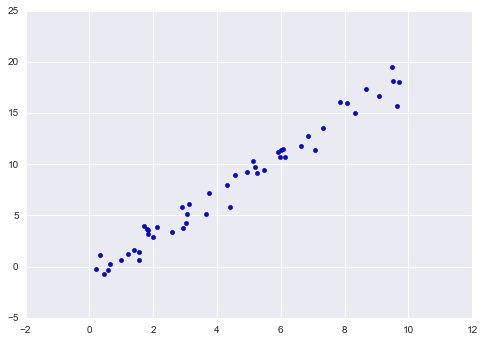

In [5]:
import matplotlib.pyplot as plt
import numpy as np

rng = np.random.RandomState(42)
x = 10 * rng.rand(50)
y = 2 * x - 1 + rng.randn(50)
plt.scatter(x, y);

With this data in place, we can use the recipe outlined earlier. Let's walk through the process: 

#### 1. Choose a class of model

In Scikit-Learn, every class of model is represented by a Python class.
So, for example, if we would like to compute a simple linear regression model, we can import the linear regression class:

In [6]:
from sklearn.linear_model import LinearRegression

Note that other more general linear regression models exist as well; you can read more about them in the [``sklearn.linear_model`` module documentation](http://Scikit-Learn.org/stable/modules/linear_model.html).

#### 2. Choose model hyperparameters

An important point is that *a class of model is not the same as an instance of a model*.

Once we have decided on our model class, there are still some options open to us.
Depending on the model class we are working with, we might need to answer one or more questions like the following:

- Would we like to fit for the offset (i.e., *y*-intercept)?
- Would we like the model to be normalized?
- Would we like to preprocess our features to add model flexibility?
- What degree of regularization would we like to use in our model?
- How many model components would we like to use?

These are examples of the important choices that must be made *once the model class is selected*.
These choices are often represented as *hyperparameters*, or parameters that must be set before the model is fit to data.
In Scikit-Learn, hyperparameters are chosen by passing values at model instantiation.
We will explore how you can quantitatively motivate the choice of hyperparameters in [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb).

For our linear regression example, we can instantiate the ``LinearRegression`` class and specify that we would like to fit the intercept using the ``fit_intercept`` hyperparameter:

In [7]:
model = LinearRegression(fit_intercept=True)
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Keep in mind that when the model is instantiated, the only action is the storing of these hyperparameter values.
In particular, we have not yet applied the model to any data: the Scikit-Learn API makes very clear the distinction between *choice of model* and *application of model to data*.

#### 3. Arrange data into a features matrix and target vector

Previously we detailed the Scikit-Learn data representation, which requires a two-dimensional features matrix and a one-dimensional target array.
Here our target variable ``y`` is already in the correct form (a length-``n_samples`` array), but we need to massage the data ``x`` to make it a matrix of size ``[n_samples, n_features]``.
In this case, this amounts to a simple reshaping of the one-dimensional array:

In [8]:
X = x[:, np.newaxis]
X.shape

(50, 1)

#### 4. Fit the model to your data

Now it is time to apply our model to data.
This can be done with the ``fit()`` method of the model:

In [9]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

This ``fit()`` command causes a number of model-dependent internal computations to take place, and the results of these computations are stored in model-specific attributes that the user can explore.
In Scikit-Learn, by convention all model parameters that were learned during the ``fit()`` process have trailing underscores; for example in this linear model, we have the following:

In [10]:
model.coef_

array([ 1.9776566])

In [11]:
model.intercept_

-0.90331072553111635

These two parameters represent the slope and intercept of the simple linear fit to the data.
Comparing to the data definition, we see that they are very close to the input slope of 2 and intercept of -1.

One question that frequently comes up regards the uncertainty in such internal model parameters.
In general, Scikit-Learn does not provide tools to draw conclusions from internal model parameters themselves: interpreting model parameters is much more a *statistical modeling* question than a *machine learning* question.
Machine learning rather focuses on what the model *predicts*.
If you would like to dive into the meaning of fit parameters within the model, other tools are available, including the [Statsmodels Python package](http://statsmodels.sourceforge.net/).

#### 5. Predict labels for unknown data

Once the model is trained, the main task of supervised machine learning is to evaluate it based on what it says about new data that was not part of the training set.
In Scikit-Learn, this can be done using the ``predict()`` method.
For the sake of this example, our "new data" will be a grid of *x* values, and we will ask what *y* values the model predicts:

In [12]:
xfit = np.linspace(-1, 11)

As before, we need to coerce these *x* values into a ``[n_samples, n_features]`` features matrix, after which we can feed it to the model:

In [13]:
Xfit = xfit[:, np.newaxis]
yfit = model.predict(Xfit)

Finally, let's visualize the results by plotting first the raw data, and then this model fit:

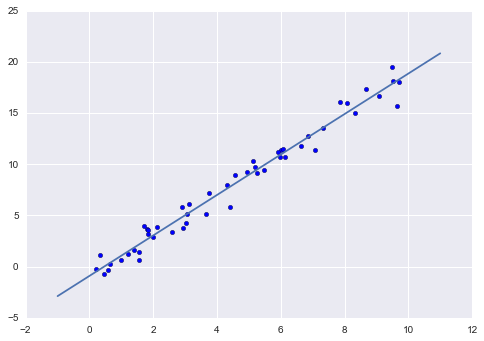

In [14]:
plt.scatter(x, y)
plt.plot(xfit, yfit);

Typically the efficacy of the model is evaluated by comparing its results to some known baseline, as we will see in the next example

### Supervised learning example: Iris classification

Let's take a look at another example of this process, using the Iris dataset we discussed earlier.
Our question will be this: given a model trained on a portion of the Iris data, how well can we predict the remaining labels?

For this task, we will use an extremely simple generative model known as Gaussian naive Bayes, which proceeds by assuming each class is drawn from an axis-aligned Gaussian distribution (see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb) for more details).
Because it is so fast and has no hyperparameters to choose, Gaussian naive Bayes is often a good model to use as a baseline classification, before exploring whether improvements can be found through more sophisticated models.

We would like to evaluate the model on data it has not seen before, and so we will split the data into a *training set* and a *testing set*.
This could be done by hand, but it is more convenient to use the ``train_test_split`` utility function:

In [15]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_iris, y_iris,
                                                random_state=1)

With the data arranged, we can follow our recipe to predict the labels:

In [16]:
from sklearn.naive_bayes import GaussianNB # 1. choose model class
model = GaussianNB()                       # 2. instantiate model
model.fit(Xtrain, ytrain)                  # 3. fit model to data
y_model = model.predict(Xtest)             # 4. predict on new data

Finally, we can use the ``accuracy_score`` utility to see the fraction of predicted labels that match their true value:

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.97368421052631582

With an accuracy topping 97%, we see that even this very naive classification algorithm is effective for this particular dataset!

### Unsupervised learning example: Iris dimensionality

As an example of an unsupervised learning problem, let's take a look at reducing the dimensionality of the Iris data so as to more easily visualize it.
Recall that the Iris data is four dimensional: there are four features recorded for each sample.

The task of dimensionality reduction is to ask whether there is a suitable lower-dimensional representation that retains the essential features of the data.
Often dimensionality reduction is used as an aid to visualizing data: after all, it is much easier to plot data in two dimensions than in four dimensions or higher!

Here we will use principal component analysis (PCA; see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)), which is a fast linear dimensionality reduction technique.
We will ask the model to return two components—that is, a two-dimensional representation of the data.

Following the sequence of steps outlined earlier, we have:

In [18]:
from sklearn.decomposition import PCA  # 1. Choose the model class
model = PCA(n_components=2)            # 2. Instantiate the model with hyperparameters
model.fit(X_iris)                      # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(X_iris)         # 4. Transform the data to two dimensions

Now let's plot the results. A quick way to do this is to insert the results into the original Iris ``DataFrame``, and use Seaborn's ``lmplot`` to show the results:

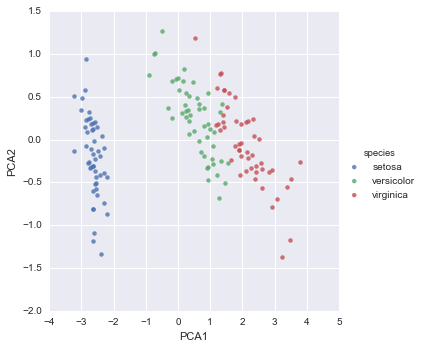

In [19]:
iris['PCA1'] = X_2D[:, 0]
iris['PCA2'] = X_2D[:, 1]
sns.lmplot("PCA1", "PCA2", hue='species', data=iris, fit_reg=False);

We see that in the two-dimensional representation, the species are fairly well separated, even though the PCA algorithm had no knowledge of the species labels!
This indicates to us that a relatively straightforward classification will probably be effective on the dataset, as we saw before.

### Unsupervised learning: Iris clustering

Let's next look at applying clustering to the Iris data.
A clustering algorithm attempts to find distinct groups of data without reference to any labels.
Here we will use a powerful clustering method called a Gaussian mixture model (GMM), discussed in more detail in [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb).
A GMM attempts to model the data as a collection of Gaussian blobs.

We can fit the Gaussian mixture model as follows:

In [20]:
from sklearn.mixture import GMM      # 1. Choose the model class
model = GMM(n_components=3,
            covariance_type='full')  # 2. Instantiate the model with hyperparameters
model.fit(X_iris)                    # 3. Fit to data. Notice y is not specified!
y_gmm = model.predict(X_iris)        # 4. Determine cluster labels

As before, we will add the cluster label to the Iris ``DataFrame`` and use Seaborn to plot the results:

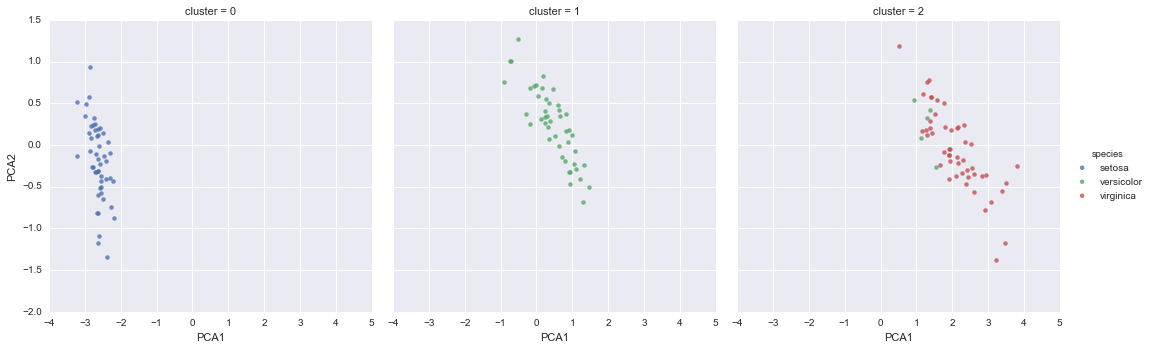

In [21]:
iris['cluster'] = y_gmm
sns.lmplot("PCA1", "PCA2", data=iris, hue='species',
           col='cluster', fit_reg=False);

By splitting the data by cluster number, we see exactly how well the GMM algorithm has recovered the underlying label: the *setosa* species is separated perfectly within cluster 0, while there remains a small amount of mixing between *versicolor* and *virginica*.
This means that even without an expert to tell us the species labels of the individual flowers, the measurements of these flowers are distinct enough that we could *automatically* identify the presence of these different groups of species with a simple clustering algorithm!
This sort of algorithm might further give experts in the field clues as to the relationship between the samples they are observing.

## Application: Exploring Hand-written Digits

To demonstrate these principles on a more interesting problem, let's consider one piece of the optical character recognition problem: the identification of hand-written digits.
In the wild, this problem involves both locating and identifying characters in an image. Here we'll take a shortcut and use Scikit-Learn's set of pre-formatted digits, which is built into the library.

### Loading and visualizing the digits data

We'll use Scikit-Learn's data access interface and take a look at this data:

In [22]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

The images data is a three-dimensional array: 1,797 samples each consisting of an 8 × 8 grid of pixels.
Let's visualize the first hundred of these:

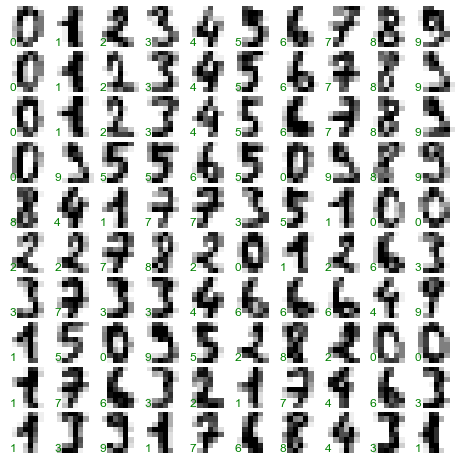

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

In order to work with this data within Scikit-Learn, we need a two-dimensional, ``[n_samples, n_features]`` representation.
We can accomplish this by treating each pixel in the image as a feature: that is, by flattening out the pixel arrays so that we have a length-64 array of pixel values representing each digit.
Additionally, we need the target array, which gives the previously determined label for each digit.
These two quantities are built into the digits dataset under the ``data`` and ``target`` attributes, respectively:

In [24]:
X = digits.data
X.shape

(1797, 64)

In [25]:
y = digits.target
y.shape

(1797,)

We see here that there are 1,797 samples and 64 features.

### Unsupervised learning: Dimensionality reduction

We'd like to visualize our points within the 64-dimensional parameter space, but it's difficult to effectively visualize points in such a high-dimensional space.
Instead we'll reduce the dimensions to 2, using an unsupervised method.
Here, we'll make use of a manifold learning algorithm called *Isomap* (see [In-Depth: Manifold Learning](05.10-Manifold-Learning.ipynb)), and transform the data to two dimensions:

In [26]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(digits.data)
data_projected = iso.transform(digits.data)
data_projected.shape

(1797, 2)

We see that the projected data is now two-dimensional.
Let's plot this data to see if we can learn anything from its structure:

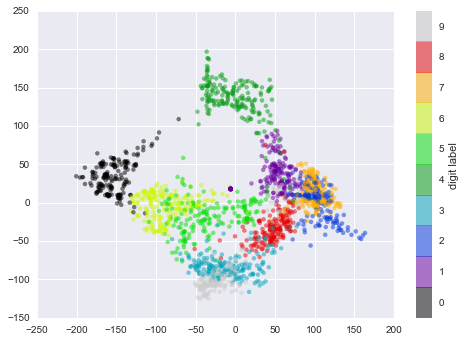

In [27]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

This plot gives us some good intuition into how well various numbers are separated in the larger 64-dimensional space. For example, zeros (in black) and ones (in purple) have very little overlap in parameter space.
Intuitively, this makes sense: a zero is empty in the middle of the image, while a one will generally have ink in the middle.
On the other hand, there seems to be a more or less continuous spectrum between ones and fours: we can understand this by realizing that some people draw ones with "hats" on them, which cause them to look similar to fours.

Overall, however, the different groups appear to be fairly well separated in the parameter space: this tells us that even a very straightforward supervised classification algorithm should perform suitably on this data.
Let's give it a try.

### Classification on digits

Let's apply a classification algorithm to the digits.
As with the Iris data previously, we will split the data into a training and testing set, and fit a Gaussian naive Bayes model:

In [28]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [29]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

Now that we have predicted our model, we can gauge its accuracy by comparing the true values of the test set to the predictions:

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.83333333333333337

With even this extremely simple model, we find about 80% accuracy for classification of the digits!
However, this single number doesn't tell us *where* we've gone wrong—one nice way to do this is to use the *confusion matrix*, which we can compute with Scikit-Learn and plot with Seaborn:

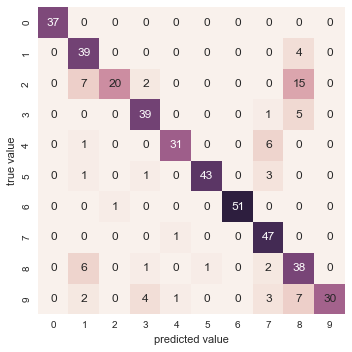

In [31]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, y_model)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

This shows us where the mis-labeled points tend to be: for example, a large number of twos here are mis-classified as either ones or eights.
Another way to gain intuition into the characteristics of the model is to plot the inputs again, with their predicted labels.
We'll use green for correct labels, and red for incorrect labels:

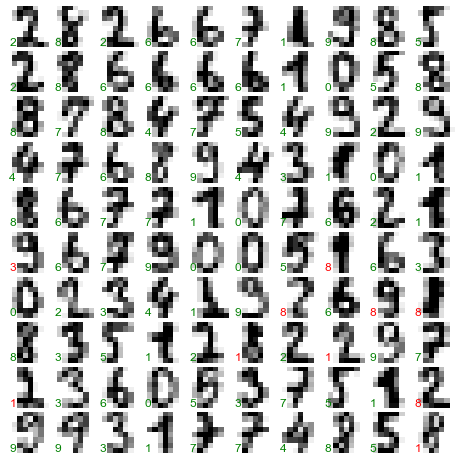

In [32]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 8, 8)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_model[i]),
            transform=ax.transAxes,
            color='green' if (ytest[i] == y_model[i]) else 'red')

Examining this subset of the data, we can gain insight regarding where the algorithm might be not performing optimally.
To go beyond our 80% classification rate, we might move to a more sophisticated algorithm such as support vector machines (see [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb)), random forests (see [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb)) or another classification approach.

## Summary

Thus far, we have covered the essential features of the Scikit-Learn data representation, and the estimator API.
Regardless of the type of estimator, the same import/instantiate/fit/predict pattern holds.
Armed with this information about the estimator API, you can explore the Scikit-Learn documentation and begin trying out various models on your data.

Next, we will explore perhaps the most important topic in machine learning: how to select and validate your model.

# Hyperparameters and Model Validation

In the previous section, we saw the basic recipe for applying a supervised machine learning model:

1. Choose a class of model
2. Choose model hyperparameters
3. Fit the model to the training data
4. Use the model to predict labels for new data

The first two pieces of this—the choice of model and choice of hyperparameters—are perhaps the most important part of using these tools and techniques effectively.
In order to make an informed choice, we need a way to *validate* that our model and our hyperparameters are a good fit to the data.
While this may sound simple, there are some pitfalls that you must avoid to do this effectively.

## Thinking about Model Validation

In principle, model validation is very simple: after choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the training data and comparing the prediction to the known value.

The following sections first show a naive approach to model validation and why it
fails, before exploring the use of holdout sets and cross-validation for more robust
model evaluation.

### Model validation the wrong way

Let's demonstrate the naive approach to validation using the Iris data, which we saw in the previous section.
We will start by loading the data:

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

Next we choose a model and hyperparameters. Here we'll use a *k*-neighbors classifier with ``n_neighbors=1``.
This is a very simple and intuitive model that says "the label of an unknown point is the same as the label of its closest training point:"

In [2]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

Then we train the model, and use it to predict labels for data we already know:

In [3]:
model.fit(X, y)
y_model = model.predict(X)

Finally, we compute the fraction of correctly labeled points:

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

We see an accuracy score of 1.0, which indicates that 100% of points were correctly labeled by our model!
But is this truly measuring the expected accuracy? Have we really come upon a model that we expect to be correct 100% of the time?

As you may have gathered, the answer is no.
In fact, this approach contains a fundamental flaw: *it trains and evaluates the model on the same data*.
Furthermore, the nearest neighbor model is an *instance-based* estimator that simply stores the training data, and predicts labels by comparing new data to these stored points: except in contrived cases, it will get 100% accuracy *every time!*

### Model validation the right way: Holdout sets

So what can be done?
A better sense of a model's performance can be found using what's known as a *holdout set*: that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance.
This splitting can be done using the ``train_test_split`` utility in Scikit-Learn:

In [5]:
from sklearn.cross_validation import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.90666666666666662

We see here a more reasonable result: the nearest-neighbor classifier is about 90% accurate on this hold-out set.
The hold-out set is similar to unknown data, because the model has not "seen" it before.

### Model validation via cross-validation

One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training.
In the above case, half the dataset does not contribute to the training of the model!
This is not optimal, and can cause problems – especially if the initial set of training data is small.

One way to address this is to use *cross-validation*; that is, to do a sequence of fits where each subset of the data is used both as a training set and as a validation set.
Visually, it might look something like this:

![](figures/05.03-2-fold-CV.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#2-Fold-Cross-Validation)

Here we do two validation trials, alternately using each half of the data as a holdout set.
Using the split data from before, we could implement it like this:

In [6]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.95999999999999996, 0.90666666666666662)

What comes out are two accuracy scores, which we could combine (by, say, taking the mean) to get a better measure of the global model performance.
This particular form of cross-validation is a *two-fold cross-validation*—that is, one in which we have split the data into two sets and used each in turn as a validation set.

We could expand on this idea to use even more trials, and more folds in the data—for example, here is a visual depiction of five-fold cross-validation:

![](figures/05.03-5-fold-CV.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#5-Fold-Cross-Validation)

Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data.
This would be rather tedious to do by hand, and so we can use Scikit-Learn's ``cross_val_score`` convenience routine to do it succinctly:

In [7]:
from sklearn.cross_validation import cross_val_score
cross_val_score(model, X, y, cv=5)

array([ 0.96666667,  0.96666667,  0.93333333,  0.93333333,  1.        ])

Repeating the validation across different subsets of the data gives us an even better idea of the performance of the algorithm.

Scikit-Learn implements a number of useful cross-validation schemes that are useful in particular situations; these are implemented via iterators in the ``cross_validation`` module.
For example, we might wish to go to the extreme case in which our number of folds is equal to the number of data points: that is, we train on all points but one in each trial.
This type of cross-validation is known as *leave-one-out* cross validation, and can be used as follows:

In [8]:
from sklearn.cross_validation import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut(len(X)))
scores

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

Because we have 150 samples, the leave one out cross-validation yields scores for 150 trials, and the score indicates either successful (1.0) or unsuccessful (0.0) prediction.
Taking the mean of these gives an estimate of the error rate:

In [9]:
scores.mean()

0.95999999999999996

Other cross-validation schemes can be used similarly.
For a description of what is available in Scikit-Learn, use IPython to explore the ``sklearn.cross_validation`` submodule, or take a look at Scikit-Learn's online [cross-validation documentation](http://scikit-learn.org/stable/modules/cross_validation.html).

## Selecting the Best Model

Now that we've seen the basics of validation and cross-validation, we will go into a litte more depth regarding model selection and selection of hyperparameters.
These issues are some of the most important aspects of the practice of machine learning, and I find that this information is often glossed over in introductory machine learning tutorials.

Of core importance is the following question: *if our estimator is underperforming, how should we move forward?*
There are several possible answers:

- Use a more complicated/more flexible model
- Use a less complicated/less flexible model
- Gather more training samples
- Gather more data to add features to each sample

The answer to this question is often counter-intuitive.
In particular, sometimes using a more complicated model will give worse results, and adding more training samples may not improve your results!
The ability to determine what steps will improve your model is what separates the successful machine learning practitioners from the unsuccessful.

### The Bias-variance trade-off

Fundamentally, the question of "the best model" is about finding a sweet spot in the tradeoff between *bias* and *variance*.
Consider the following figure, which presents two regression fits to the same dataset:

![bias variance tradeoff](assets/bias-variance1.png)

It is clear that neither of these models is a particularly good fit to the data, but they fail in different ways.

The model on the left attempts to find a straight-line fit through the data.
Because the data are intrinsically more complicated than a straight line, the straight-line model will never be able to describe this dataset well.
Such a model is said to *underfit* the data: that is, it does not have enough model flexibility to suitably account for all the features in the data; another way of saying this is that the model has high *bias*.

The model on the right attempts to fit a high-order polynomial through the data.
Here the model fit has enough flexibility to nearly perfectly account for the fine features in the data, but even though it very accurately describes the training data, its precise form seems to be more reflective of the particular noise properties of the data rather than the intrinsic properties of whatever process generated that data.
Such a model is said to *overfit* the data: that is, it has so much model flexibility that the model ends up accounting for random errors as well as the underlying data distribution; another way of saying this is that the model has high *variance*.

To look at this in another light, consider what happens if we use these two models to predict the y-value for some new data.
In the following diagrams, the red/lighter points indicate data that is omitted from the training set:

![](assets/bias-variance2.png)

The score here is the $R^2$ score, or [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), which measures how well a model performs relative to a simple mean of the target values. $R^2=1$ indicates a perfect match, $R^2=0$ indicates the model does no better than simply taking the mean of the data, and negative values mean even worse models.
From the scores associated with these two models, we can make an observation that holds more generally:

- For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
- For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.

If we imagine that we have some ability to tune the model complexity, we would expect the training score and validation score to behave as illustrated in the following figure:

![](assets/validation-curve.png)

The diagram shown here is often called a *validation curve*, and we see the following essential features:

- The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.
- For very low model complexity (a high-bias model), the training data is under-fit, which means that the model is a poor predictor both for the training data and for any previously unseen data.
- For very high model complexity (a high-variance model), the training data is over-fit, which means that the model predicts the training data very well, but fails for any previously unseen data.
- For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.

The means of tuning the model complexity varies from model to model; when we discuss individual models in depth in later sections, we will see how each model allows for such tuning.

### Validation curves in Scikit-Learn

Let's look at an example of using cross-validation to compute the validation curve for a class of models.
Here we will use a *polynomial regression* model: this is a generalized linear model in which the degree of the polynomial is a tunable parameter.
For example, a degree-1 polynomial fits a straight line to the data; for model parameters $a$ and $b$:

$$
y = ax + b
$$

A degree-3 polynomial fits a cubic curve to the data; for model parameters $a, b, c, d$:

$$
y = ax^3 + bx^2 + cx + d
$$

We can generalize this to any number of polynomial features.
In Scikit-Learn, we can implement this with a simple linear regression combined with the polynomial preprocessor.
We will use a *pipeline* to string these operations together (we will discuss polynomial features and pipelines more fully in [Feature Engineering](05.04-Feature-Engineering.ipynb)):

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Now let's create some data to which we will fit our model:

In [6]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

We can now visualize our data, along with polynomial fits of several degrees:

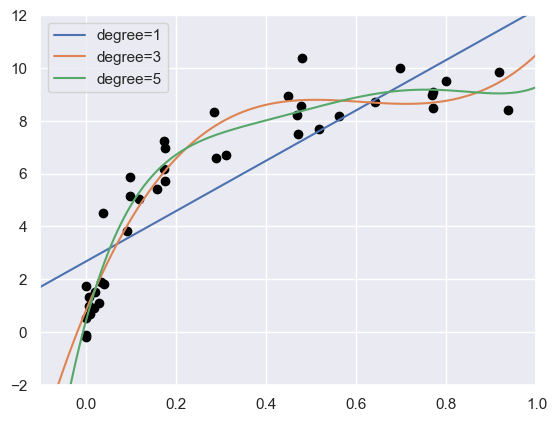

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

The knob controlling model complexity in this case is the degree of the polynomial, which can be any non-negative integer.
A useful question to answer is this: what degree of polynomial provides a suitable trade-off between bias (under-fitting) and variance (over-fitting)?

We can make progress in this by visualizing the validation curve for this particular data and model; this can be done straightforwardly using the ``validation_curve`` convenience routine provided by Scikit-Learn.
Given a model, data, parameter name, and a range to explore, this function will automatically compute both the training score and validation score across the range:

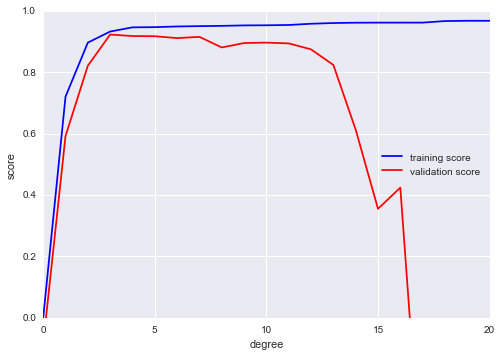

In [13]:
from sklearn.learning_curve import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

This shows precisely the qualitative behavior we expect: the training score is everywhere higher than the validation score; the training score is monotonically improving with increased model complexity; and the validation score reaches a maximum before dropping off as the model becomes over-fit.

From the validation curve, we can read-off that the optimal trade-off between bias and variance is found for a third-order polynomial; we can compute and display this fit over the original data as follows:

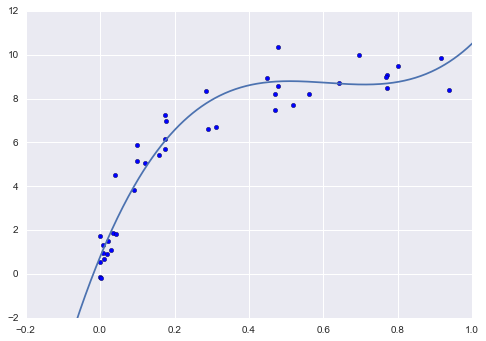

In [14]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

Notice that finding this optimal model did not actually require us to compute the training score, but examining the relationship between the training score and validation score can give us useful insight into the performance of the model.

## Learning Curves

One important aspect of model complexity is that the optimal model will generally depend on the size of your training data.
For example, let's generate a new dataset with a factor of five more points:

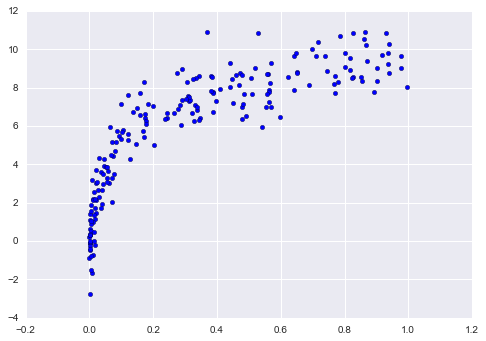

In [15]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

We will duplicate the preceding code to plot the validation curve for this larger dataset; for reference let's over-plot the previous results as well:

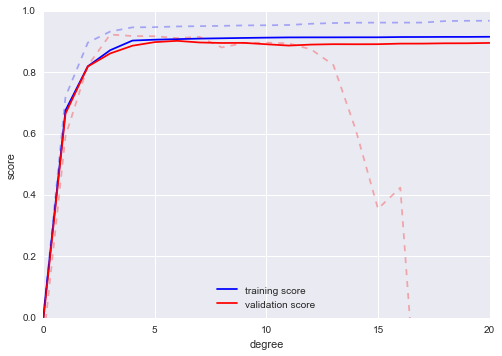

In [16]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

The solid lines show the new results, while the fainter dashed lines show the results of the previous smaller dataset.
It is clear from the validation curve that the larger dataset can support a much more complicated model: the peak here is probably around a degree of 6, but even a degree-20 model is not seriously over-fitting the data—the validation and training scores remain very close.

Thus we see that the behavior of the validation curve has not one but two important inputs: the model complexity and the number of training points.
It is often useful to to explore the behavior of the model as a function of the number of training points, which we can do by using increasingly larger subsets of the data to fit our model.
A plot of the training/validation score with respect to the size of the training set is known as a *learning curve.*

The general behavior we would expect from a learning curve is this:

- A model of a given complexity will *overfit* a small dataset: this means the training score will be relatively high, while the validation score will be relatively low.
- A model of a given complexity will *underfit* a large dataset: this means that the training score will decrease, but the validation score will increase.
- A model will never, except by chance, give a better score to the validation set than the training set: this means the curves should keep getting closer together but never cross.

With these features in mind, we would expect a learning curve to look qualitatively like that shown in the following figure:

![](assets/learning-curve.png)

The notable feature of the learning curve is the convergence to a particular score as the number of training samples grows.
In particular, once you have enough points that a particular model has converged, *adding more training data will not help you!*
The only way to increase model performance in this case is to use another (often more complex) model.

### Learning curves in Scikit-Learn

Scikit-Learn offers a convenient utility for computing such learning curves from your models; here we will compute a learning curve for our original dataset with a second-order polynomial model and a ninth-order polynomial:

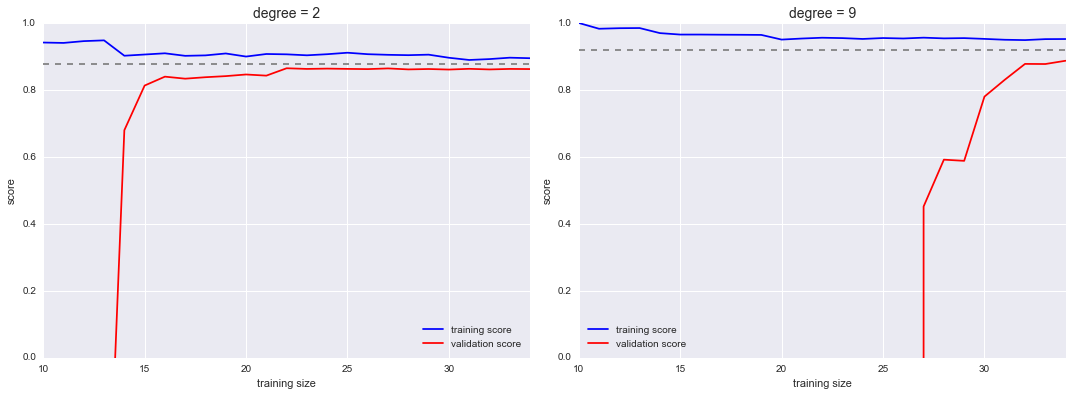

In [17]:
from sklearn.learning_curve import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

This is a valuable diagnostic, because it gives us a visual depiction of how our model responds to increasing training data.
In particular, when your learning curve has already converged (i.e., when the training and validation curves are already close to each other) *adding more training data will not significantly improve the fit!*
This situation is seen in the left panel, with the learning curve for the degree-2 model.

The only way to increase the converged score is to use a different (usually more complicated) model.
We see this in the right panel: by moving to a much more complicated model, we increase the score of convergence (indicated by the dashed line), but at the expense of higher model variance (indicated by the difference between the training and validation scores).
If we were to add even more data points, the learning curve for the more complicated model would eventually converge.

Plotting a learning curve for your particular choice of model and dataset can help you to make this type of decision about how to move forward in improving your analysis.

## Validation in Practice: Grid Search

The preceding discussion is meant to give you some intuition into the trade-off between bias and variance, and its dependence on model complexity and training set size.
In practice, models generally have more than one knob to turn, and thus plots of validation and learning curves change from lines to multi-dimensional surfaces.
In these cases, such visualizations are difficult and we would rather simply find the particular model that maximizes the validation score.

Scikit-Learn provides automated tools to do this in the grid search module.
Here is an example of using grid search to find the optimal polynomial model.
We will explore a three-dimensional grid of model features; namely the polynomial degree, the flag telling us whether to fit the intercept, and the flag telling us whether to normalize the problem.
This can be set up using Scikit-Learn's ``GridSearchCV`` meta-estimator:

In [18]:
from sklearn.grid_search import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

Notice that like a normal estimator, this has not yet been applied to any data.
Calling the ``fit()`` method will fit the model at each grid point, keeping track of the scores along the way:

In [19]:
grid.fit(X, y);

Now that this is fit, we can ask for the best parameters as follows:

In [20]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

Finally, if we wish, we can use the best model and show the fit to our data using code from before:

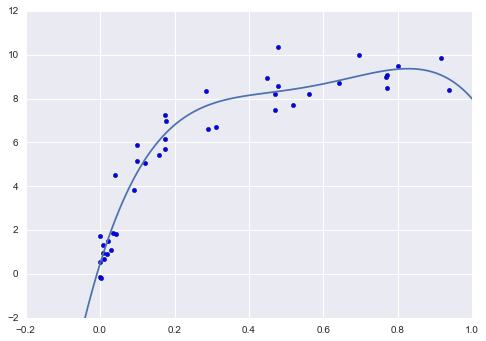

In [21]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test, hold=True);
plt.axis(lim);

The grid search provides many more options, including the ability to specify a custom scoring function, to parallelize the computations, to do randomized searches, and more.

## Summary

In this section, we have begun to explore the concept of model validation and hyperparameter optimization, focusing on intuitive aspects of the bias–variance trade-off and how it comes into play when fitting models to data.
In particular, we found that the use of a validation set or cross-validation approach is *vital* when tuning parameters in order to avoid over-fitting for more complex/flexible models.

Throughout the remainder of this course, we will expand on these fundamentals, and dive more deeply into different models.